<a href="https://colab.research.google.com/github/DanielhCarranza/Curso-Deep-Learning/blob/master/Transformers_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers
### References
* [Pytorch Seq2Seq](https://github.com/bentrevett/pytorch-seq2seq)
* [Fastai Transformer](https://github.com/fastai/course-nlp/blob/master/8-translation-transformer.ipynb)
* [Transformers from Scratch](http://www.peterbloem.nl/blog/transformers)

![texto alternativo](https://github.com/bentrevett/pytorch-seq2seq/raw/6559ece8dcb41d2cb9cfe479c7442c8d6c0d90bb/assets/transformer1.png)


In [ ]:
%%bash
git clone https://github.com/fastai/course-v4.git
pip install -r course-v4/requirements.txt
python -m spacy download de
pip install torch torchvision torchtext=='0.6'
pip install git+https://github.com/PetrochukM/PyTorch-NLP.git

In [ ]:
import math
import time
import random

import spacy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.data import Field, BucketIterator
from torchtext.datasets import TranslationDataset, Multi30k
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from torchnlp.datasets import multi30k_dataset 
train = multi30k_dataset(train=True)

training.tar.gz: 1.21MB [00:00, 4.21MB/s]                           
validation.tar.gz: 49.2kB [00:00, 422kB/s]                             
mmt16_task1_test.tar.gz: 49.2kB [00:00, 424kB/s]                             


In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [ ]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))
# train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'),
#                                                     root='data',test='test', 
#                                                     fields = (SRC, TRG))

training.tar.gz:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 6.49MB/s]
validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 1.78MB/s]

downloading validation.tar.gz
downloading mmt_task1_test2016.tar.gz



mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 1.69MB/s]


In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [ ]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

In [ ]:
def one_batch(iterator):
  batch= next(iter(iterator))
  return batch.src, batch.trg 
xb, yb = one_batch(train_iterator)
xb, yb = xb.to(device), yb.to(device)
xb.shape,  yb.shape

(torch.Size([128, 23]), torch.Size([128, 21]))

### Token & Positional Embedings
We use learned embeddings to convert the input tokens and output tokens to vectors of dimension $d_{model}$. 
In our model, we share the same weight matrix between the two embedding layers and the pre-softmax
linear transformation. In the embedding layers, we multiply those weights by $\sqrt{d_{model}}$.

**Positional Encodings**

Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence.
$$\begin{aligned}
P E_{(p o s, 2 i)} &=\sin \left(p o s / 10000^{2 i / d_{\text {model }}}\right) \\
P E_{(p o s, 2 i+1)} &=\cos \left(p o s / 10000^{2 i / d_{\text {model }}}\right)
\end{aligned}$$

In [ ]:
class TransformerEmbedding(nn.Module):
  def __init__(self, inp_dim, emb_dim, dropout, device, max_lenght=100):
    super().__init__()
    self.device=device
    self.tok_emb = nn.Embedding(inp_dim, emb_dim)
    self.pos_emb = nn.Embedding(max_lenght, emb_dim)
    self.drop    = nn.Dropout(dropout)
    self.scale   = torch.sqrt(torch.FloatTensor([emb_dim])).to(device)
  def forward(self, inp):
    bs, sl  = inp.shape
    pos     = torch.arange(0, sl).repeat(bs,1).to(self.device)
    embeded = self.drop((self.tok_emb(inp)*self.scale) + self.pos_emb(pos))
    return embeded


In [ ]:
inp_dim, emb_dim, drop = len(SRC.vocab), 256, 0.1
transformer_emb = TransformerEmbedding(inp_dim, emb_dim, drop, device).to(device)
embeded = transformer_emb(xb); embeded.shape

torch.Size([128, 23, 256])

### Multi-Head Attention
$$\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}\right) V$$

$$\begin{aligned}
\text { MultiHead }(Q, K, V) &\left.=\text { Concat(head }_{1}, \ldots, \text { head }_{\mathrm{h}}\right) W^{O} \\
\text { where head }_{\mathrm{i}} &=\text { Attention }\left(Q W_{i}^{Q}, K W_{i}^{K}, V W_{i}^{V}\right)
\end{aligned}$$

Where the projections are parameter matrices are $W_{i}^{Q} \in \mathbb{R}^{d_{\text {model }} \times d_{k}}, W_{i}^{K} \in \mathbb{R}^{d_{\text {model }} \times d_{k}}, W_{i}^{V} \in \mathbb{R}^{d_{\text {model }} \times d_{v}}$
and $W^{O} \in \mathbb{R}^{h d_{v} \times d_{\text {model }}}$


`dk = dv = dmodel/h, dmodel = hid_dim, dk = head_dim, h = n_heads
`

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, hid_dim,  n_heads, dropout, device, bias=True):
    super().__init__()
    assert hid_dim % n_heads == 0
    head_dim = hid_dim//n_heads 
    self.n_heads, self.hid_dim, self.head_dim = n_heads, hid_dim, head_dim
    self.fc_q, self.fc_k, self.fc_v, self.fc_o = [nn.Linear(
                hid_dim, hid_dim, bias=bias) for _ in range(4)]
    self.dropout = nn.Dropout(dropout)
    self.scale   = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
  def modify_dims(self, layer, bs):
    return layer.view(bs, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
  def forward(self, q, k, v, mask=None):
    bs = q.shape[0]
    Q, K, V = self.fc_q(q), self.fc_k(k), self.fc_v(v)
    Q, K, V = map(lambda o: self.modify_dims(o,bs), (Q,K,V))
    attn_score  = (Q @ K.permute(0, 1, 3, 2)) / self.scale
    if mask is not None: attn_score = attn_score.masked_fill(mask == 0, -1e10)
    attn_prob = torch.softmax(attn_score, dim=-1) # [bs, h, sl, sl]
    attn_vc = self.dropout(attn_prob) @ V # [bs, h, sl, sl] [bs, h, sl , hid]
    attn_vc = attn_vc.permute(0,2,1,3).contiguous().view(bs, -1, self.hid_dim)
    scale_dot_attn  = self.fc_o(attn_vc)     
    return scale_dot_attn, attn_prob 

In [ ]:
# class MultiHeadAttentionLayer(nn.Module):
#     def __init__(self, hid_dim, n_heads, dropout, device):
#         super().__init__()
#         assert hid_dim % n_heads == 0
#         self.hid_dim, self.n_heads = hid_dim, n_heads
#         self.head_dim = hid_dim // n_heads
#         self.fc_q, self.fc_k, self.fc_v, self.fc_o = [nn.Linear(
#                     hid_dim, hid_dim) for _ in range(4)]
#         self.dropout = nn.Dropout(dropout)
#         self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
#     def modify_dims(self, layer, bs):
#         return layer.view(bs, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
#     def forward(self, query, key, value, mask = None):
#         bs = query.shape[0]
#         Q, K, V = self.fc_q(query), self.fc_k(key), self.fc_v(value)
#         Q, K, V = map(lambda o: self.modify_dims(o,bs), (Q,K,V))       
#         energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
#         if mask is not None: energy = energy.masked_fill(mask == 0, -1e10)
#         attention = torch.softmax(energy, dim = -1)
#         x = torch.matmul(self.dropout(attention), V)
#         x = x.permute(0, 2, 1, 3).contiguous().view(bs, -1, self.hid_dim)
#         x = self.fc_o(x)
#         return x, attention

In [ ]:
emb_dim, hid_dim, heads = 256, 256, 8
matt = MultiHeadAttention(hid_dim, heads,drop, device).to(device)

In [ ]:
# %debug
sdattn, attn = matt(*[embeded]*3)
sdattn.shape, attn.shape

(torch.Size([128, 23, 256]), torch.Size([128, 8, 23, 23]))

### Feed-Forward-Network
The dimensionality of input and output is $d_{model} = 512$, and the inner-layer has dimensionality
$d_{ff} = 2048$.
$$\mathrm{FFN}(x)=\max \left(0, x W_{1}+b_{1}\right) W_{2}+b_{2}$$

In [ ]:
# class FFN(nn.Module):
#   def __init__(self, hid_dim, inner_dim, dropout):
#     super().__init__()
#     self.layers = nn.Sequential(nn.Linear(hid_dim, inner_dim),
#                            nn.ReLU(),
#                            nn.Dropout(dropout),
#                            nn.Linear(inner_dim, hid_dim))
#     self.norm_ffn= nn.LayerNorm(hid_dim)
#   def forward(self, inp):
#     return self.norm_ffn(inp + self.layers(inp) )   

class FFN(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):        
        x = self.dropout(torch.relu(self.fc_1(x)))
        return self.fc_2(x) 

In [ ]:
hid_dim, inner_dim, drop = 256,512, 0.1 
ffn = FFN(hid_dim,inner_dim, drop).to(device)
ffn(sdattn).shape

torch.Size([128, 23, 256])

## Encoder 


In [ ]:
class EncoderLayer(nn.Module):
  def __init__(self, hid_dim, inner_dim, n_heads, dropout, device):
    super().__init__()
    self.attention = MultiHeadAttention(hid_dim, n_heads,  dropout, device)
    self.ffn_layer = FFN(hid_dim, inner_dim, dropout)
    self.ln_attn   = nn.LayerNorm(hid_dim)
    self.ln_ffn    = nn.LayerNorm(hid_dim)
    self.dropout   = nn.Dropout(dropout)

  def forward(self, q, k, v, mask=None):
    attn, _    = self.attention(q, k, v, mask)
    attn_layer = self.ln_attn(q + self.dropout(attn))
    ffn        = self.ffn_layer(attn_layer)
    enc_out    = self.ln_ffn(attn_layer + self.dropout(ffn))
    return enc_out

In [ ]:
emb_dim, hid_dim, inner_dim, n_heads, drop = 256, 256,512, 8, 0.1
enclayer = EncoderLayer(hid_dim, inner_dim, n_heads, drop, device).to(device)

In [ ]:
src_pad_idx = SRC.vocab.stoi[SRC.pad_token]
src_mask = xb[:, None, None, :] != src_pad_idx 
enclayer(*[embeded]*3, src_mask).shape

torch.Size([128, 23, 256])

In [ ]:
class Encoder(nn.Module):
  def __init__(self, inp_dim, emb_dim, hid_dim, inner_dim, n_heads,n_layers, dropout, device):
    super().__init__()
    self.embeded = TransformerEmbedding(inp_dim, emb_dim, dropout, device)
    self.layers  = nn.ModuleList([EncoderLayer(hid_dim, inner_dim,  
                                               n_heads, dropout,device) 
                                                 for _ in range(n_layers)])
  def forward(self, inp, mask=None):
    src   = self.embeded(inp)
    for layer in self.layers: src = layer(src,src,src, mask)
    return src

In [ ]:
emb_dim, hid_dim, inner_dim, n_heads,n_layers, drop = 256, 256,512, 8, 6, 0.1
enc = Encoder(inp_dim, emb_dim, hid_dim, inner_dim, n_heads,n_layers, drop, device).to(device)

In [ ]:
enc_out = enc(xb, src_mask); enc_out.shape

torch.Size([128, 23, 256])

### Decoder

In [ ]:
class DecoderLayer(nn.Module):
  def __init__(self, hid_dim, inner_dim, n_heads, dropout, device):
    super().__init__()
    self.masked_attn = MultiHeadAttention(hid_dim, n_heads,dropout, device)
    self.enc_attn    = MultiHeadAttention(hid_dim, n_heads,dropout, device)
    self.ffn_layer   = FFN(hid_dim, inner_dim, dropout)
    self.ln_masked   = nn.LayerNorm(hid_dim)
    self.ln_attn     = nn.LayerNorm(hid_dim)
    self.ln_ffn      = nn.LayerNorm(hid_dim)
    self.dropout     = nn.Dropout(dropout)

  def forward(self, q, k, v, trg_mask, src_mask, enc_out):
    dot_attn, _   = self.masked_attn(q, k, v, trg_mask)
    masked_layer  = self.ln_masked(q + self.dropout(dot_attn))
    dot_attn, attn= self.enc_attn(masked_layer, enc_out, enc_out, src_mask)
    attn_layer    = self.ln_attn(masked_layer + self.dropout(dot_attn))
    ffn_layer     = self.ffn_layer(attn_layer)
    dec_out       = self.ln_ffn(attn_layer + self.dropout(ffn_layer))
    return dec_out, attn

In [ ]:
emb_dim, hid_dim, inner_dim, n_heads, drop = 256, 256,512, 8, 0.1
declayer = DecoderLayer(hid_dim, inner_dim, n_heads, drop, device).to(device)

In [ ]:
out_dim, emb_dim, drop = len(TRG.vocab), 256, 0.1
trg_embeding = TransformerEmbedding(out_dim, emb_dim, drop, device).to(device)
trg_emb = trg_embeding(yb); trg_emb.shape

torch.Size([128, 21, 256])

In [ ]:
trg_pad_idx = TRG.vocab.stoi[TRG.pad_token]
bs, trg_sl = yb.shape
src_mask = xb[:, None, None, :] != src_pad_idx 

pad_mask = yb[:, None, None,:] != trg_pad_idx 
tri_mask = torch.tril(yb.new_ones((trg_sl, trg_sl), device=device)).bool()
trg_mask = (pad_mask & tri_mask )

print(f'SRC Mask {src_mask.shape}, TRG Mask {trg_mask.shape}')
dec_out, attn = declayer(*[trg_emb]*3, trg_mask, src_mask, enc_out)
dec_out.shape, attn.shape

SRC Mask torch.Size([128, 1, 1, 23]), TRG Mask torch.Size([128, 1, 21, 21])


(torch.Size([128, 21, 256]), torch.Size([128, 8, 21, 23]))

In [ ]:
class Decoder(nn.Module):
  def __init__(self, out_dim, emb_dim, hid_dim, inner_dim, n_heads, n_layers, drop, device):
    super().__init__()
    self.embeded = TransformerEmbedding(out_dim, emb_dim, drop, device)
    self.layers  = nn.ModuleList([DecoderLayer(hid_dim, inner_dim, 
                                               n_heads, drop, device) 
                                               for _ in range(n_layers)])
    self.fc_out = nn.Linear(hid_dim, out_dim)
  def forward(self, trg, trg_mask, src_mask, enc_out):
    trg = self.embeded(trg)
    for layer  in self.layers: 
      trg, attn = layer(trg,trg,trg, trg_mask, src_mask, enc_out)
    dec_out = self.fc_out(trg)
    return dec_out, attn

In [ ]:
out_dim, emb_dim, hid_dim, inner_dim, n_heads, drop =len(TRG.vocab), 256, 256,512, 8, 0.1
dec = Decoder(out_dim, emb_dim, hid_dim, inner_dim, n_heads, n_layers, drop, device).to(device)

In [ ]:
dec_out, attn = dec(yb, trg_mask, src_mask, enc_out)
dec_out.shape, attn.shape

(torch.Size([128, 21, 5893]), torch.Size([128, 8, 21, 23]))

In [ ]:
class Transformer(nn.Module):
  def __init__(self, encoder, decoder,src_pad_idx, trg_pad_idx, device):
    super().__init__()
    self.encoder, self.decoder, self.device = encoder, decoder, device
    self.src_pad_idx, self.trg_pad_idx = src_pad_idx, trg_pad_idx
  def src_mask(self, src):
    return (src != self.src_pad_idx)[:,None, None, :]
  def trg_mask(self, trg):
    trg_sl = trg.shape[1]
    pad_mask = (trg != self.trg_pad_idx)[:,None, None,:]
    tri_mask = torch.tril(torch.ones((trg_sl,trg_sl), device=self.device )).bool()
    return pad_mask & tri_mask
  def forward(self, src, trg):
    src_mask, trg_mask = self.src_mask(src), self.trg_mask(trg)
    enc_out            = self.encoder(src, src_mask)
    dec_out, attention = self.decoder(trg, trg_mask, src_mask, enc_out)
    return dec_out, attention

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
EMB_DIM = HID_DIM
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_INNER_DIM = 512
DEC_INNER_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
trg_pad_idx = TRG.vocab.stoi[TRG.pad_token]
src_pad_idx = SRC.vocab.stoi[SRC.pad_token]

enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_INNER_DIM, 
              ENC_HEADS, ENC_LAYERS, ENC_DROPOUT, device).to(device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_INNER_DIM, 
              DEC_HEADS, DEC_LAYERS, DEC_DROPOUT, device).to(device)

In [ ]:
model = Transformer(enc, dec, src_pad_idx, trg_pad_idx, device).to(device)

In [ ]:
#output = [batch size, trg len, output dim]
#attention = [batch size, n heads, trg len, src len]
preds, attn = model(xb,yb)
preds.shape, attn.shape

(torch.Size([128, 21, 5893]), torch.Size([128, 8, 21, 23]))

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,853 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
model.apply(initialize_weights);

In [ ]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = trg_pad_idx)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 40s
	Train Loss: 4.239 | Train PPL:  69.372
	 Val. Loss: 3.035 |  Val. PPL:  20.811
Epoch: 02 | Time: 0m 39s
	Train Loss: 2.824 | Train PPL:  16.852
	 Val. Loss: 2.305 |  Val. PPL:  10.019
Epoch: 03 | Time: 0m 39s
	Train Loss: 2.236 | Train PPL:   9.357
	 Val. Loss: 1.985 |  Val. PPL:   7.279
Epoch: 04 | Time: 0m 39s
	Train Loss: 1.885 | Train PPL:   6.589
	 Val. Loss: 1.815 |  Val. PPL:   6.140
Epoch: 05 | Time: 0m 39s
	Train Loss: 1.642 | Train PPL:   5.165
	 Val. Loss: 1.715 |  Val. PPL:   5.554
Epoch: 06 | Time: 0m 39s
	Train Loss: 1.453 | Train PPL:   4.278
	 Val. Loss: 1.666 |  Val. PPL:   5.292
Epoch: 07 | Time: 0m 39s
	Train Loss: 1.303 | Train PPL:   3.682
	 Val. Loss: 1.643 |  Val. PPL:   5.173
Epoch: 08 | Time: 0m 39s
	Train Loss: 1.177 | Train PPL:   3.243
	 Val. Loss: 1.637 |  Val. PPL:   5.142
Epoch: 09 | Time: 0m 39s
	Train Loss: 1.066 | Train PPL:   2.905
	 Val. Loss: 1.654 |  Val. PPL:   5.227
Epoch: 10 | Time: 0m 39s
	Train Loss: 0.972 | Train PPL

In [ ]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.655 | Test PPL:   5.233 |


In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, trg_mask, src_mask, enc_src)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [ ]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [ ]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


In [ ]:
# %debug
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'walks', 'by', 'a', 'gate', '.', '<eos>']


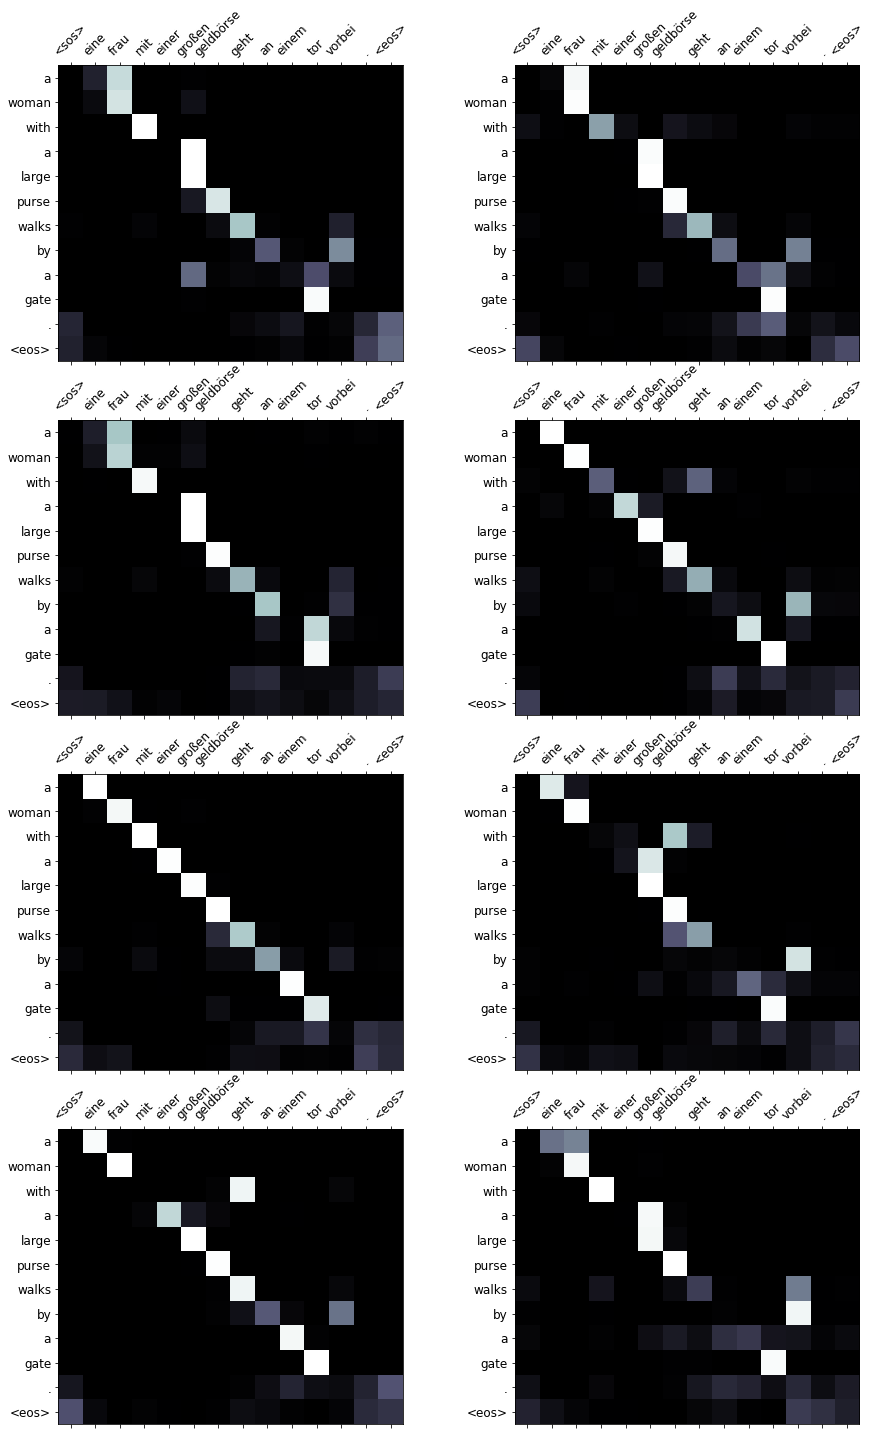

In [ ]:
display_attention(src, translation, attention)

In [ ]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'running', 'after', 'the', 'black', 'dog', '.', '<eos>']


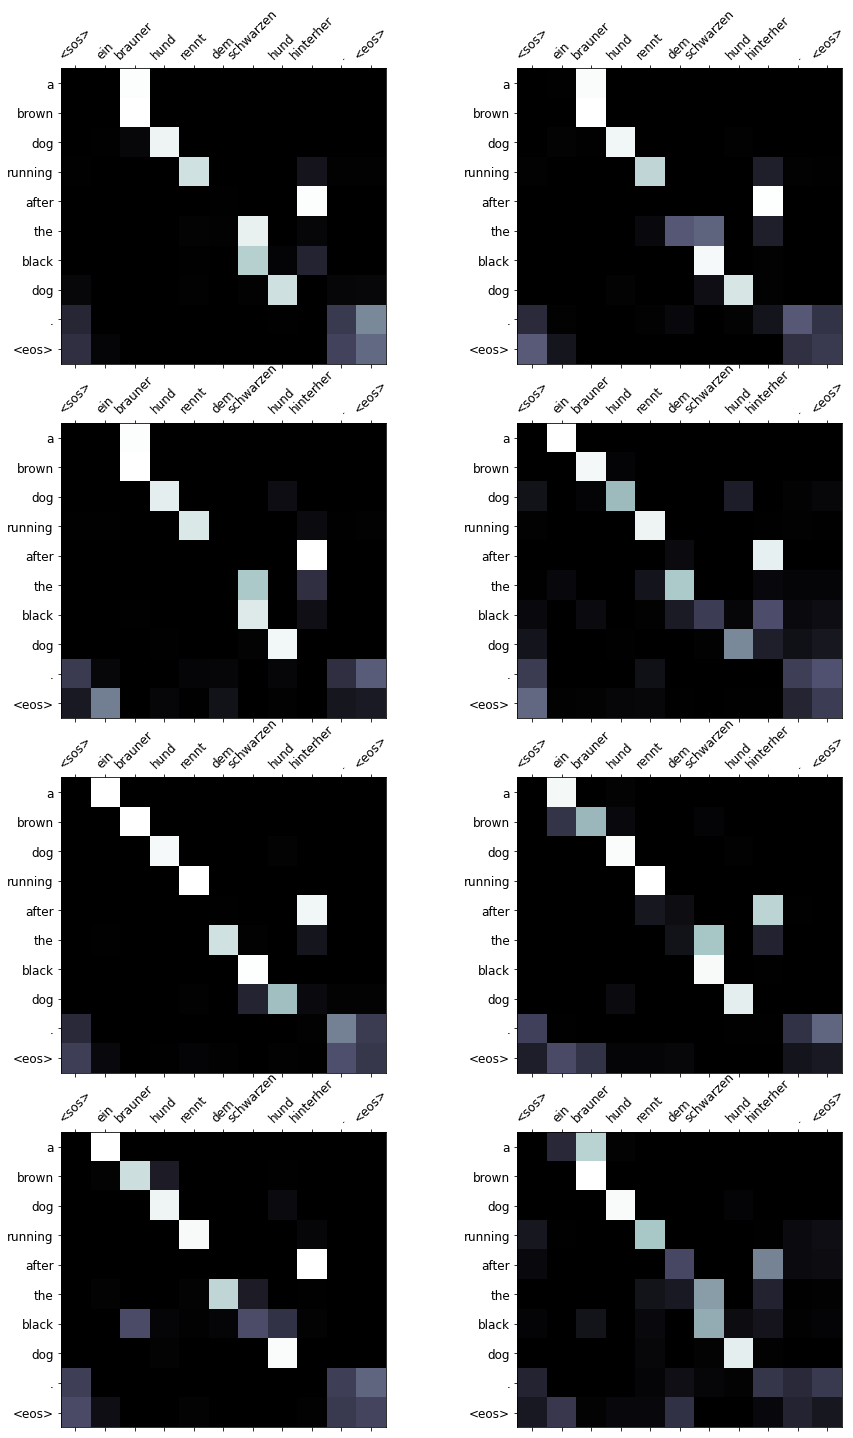

In [ ]:
display_attention(src, translation, attention)

In [ ]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']


In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'mother', 'and', 'her', 'young', 'son', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.', '<eos>']


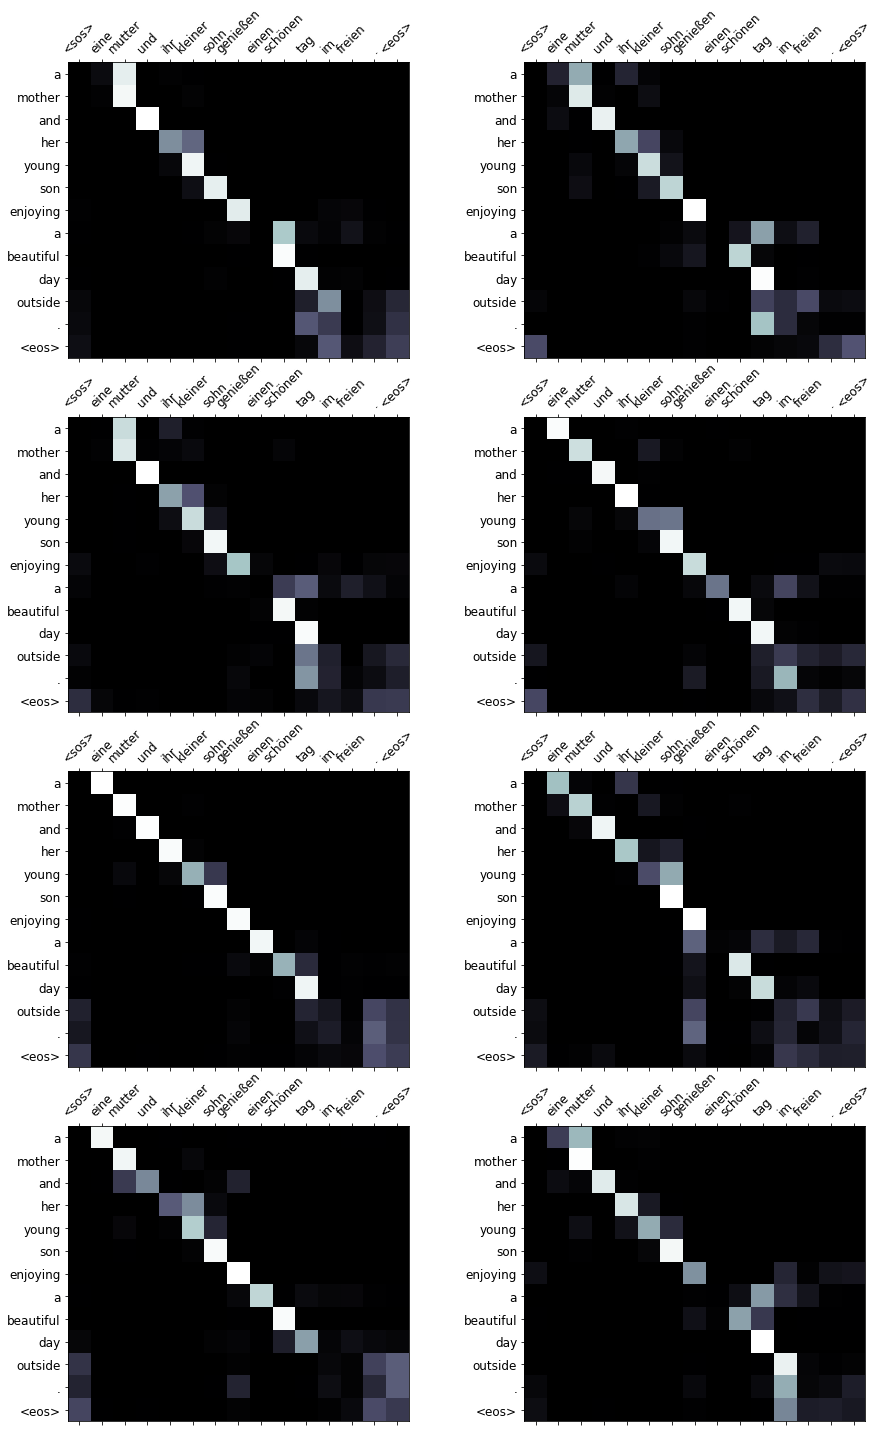

In [ ]:
display_attention(src, translation, attention)

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 35.87
